# Using pre-trained word embeddings


## Setup

In [1]:
import numpy as np
import io
import os
import re
import shutil
import string

import tensorflow as tf
from tensorflow import keras

## Introduction

In this example, we show how to train a text classification model that uses pre-trained
word embeddings.

We'll work with threat intelligence report dataset.

## Download the Threat Intelligence data

In [2]:
url = 'https://github.com/eyalmazuz/AttackAttributionDataset/archive/refs/heads/master.zip' 

dataset = tf.keras.utils.get_file('master.zip', url,
                                  extract=True, cache_dir='.',
                                  cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'AttackAttributionDataset-master')
print(dataset_dir)
os.listdir(dataset_dir)

1196032/Unknown - 0s 0us/step./AttackAttributionDataset-master


['README.md',
 'FIN7',
 'APT28',
 'APT17',
 'OilRig',
 'Lazarus',
 'APT3',
 'menuPass',
 'APT29',
 'DeepPanda',
 'RocketKitten',
 'Turla',
 'Winnti']

## Shuffle and split the data into training & validation sets

In [3]:
batch_size = 5
seed = 42

train_ds = tf.keras.utils.text_dataset_from_directory(
    'AttackAttributionDataset-master',
    batch_size=batch_size,
    validation_split=0.15,
    subset='training',
    seed=seed)


val_ds = tf.keras.utils.text_dataset_from_directory(
    'AttackAttributionDataset-master', batch_size=batch_size, validation_split=0.15,
    subset='validation', seed=seed)

AUTOTUNE = tf.data.AUTOTUNE

class_names = train_ds.class_names

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 238 files belonging to 12 classes.
Using 203 files for training.
Found 238 files belonging to 12 classes.
Using 35 files for validation.


## Create a vocabulary index

Let's use the `TextVectorization` to index the vocabulary found in the dataset.
Later, we'll use the same layer instance to vectorize the samples.

Our layer will only consider the top 20,000 words, and will truncate or pad sequences to
be actually 200 tokens long.

In [4]:
from tensorflow.keras.layers import TextVectorization

# Create a custom standardization function to strip HTML break tags '<br />'.
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation), '')


# Vocabulary size and number of words in a sequence.
vocab_size = 100000
sequence_length = 1000

# Use the text vectorization layer to normalize, split, and map strings to
# integers. Note that the layer uses the custom standardization defined above.
# Set maximum_sequence length as all samples are not of the same length.
vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length)

text_ds = train_ds.map(lambda x, y: x)
vectorize_layer.adapt(text_ds)

You can retrieve the computed vocabulary used via `vectorizer.get_vocabulary()`. Let's
print the top 5 words:

In [5]:
vectorize_layer.get_vocabulary()[:5]

['', '[UNK]', 'the', 'to', 'of']

Let's vectorize a test sentence:

In [6]:
output = vectorize_layer([["the cat sat on the mat"]])
output.numpy()[0, :6]

array([    2, 17731, 12626,    14,     2,     1])

As you can see, "the" gets represented as "2". Why not 0, given that "the" was the first
word in the vocabulary? That's because index 0 is reserved for padding and index 1 is
reserved for "out of vocabulary" tokens.

Here's a dict mapping words to their indices:

In [7]:
voc = vectorize_layer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

As you can see, we obtain the same encoding as above for our test sentence:

In [8]:
test = ["the", "cat", "sat", "on", "the", "mat"]
# [word_index[w] for w in test]

## Load pre-trained word embeddings

Let's download pre-trained GloVe embeddings (a 822M zip file).

In [9]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip


--2022-09-07 13:40:07--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-09-07 13:40:07--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-09-07 13:40:08--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

The archive contains text-encoded vectors of various sizes: 50-dimensional,
100-dimensional, 200-dimensional, 300-dimensional. We'll use the 100D ones.

Let's make a dict mapping words (strings) to their NumPy vector representation:

In [10]:
path_to_glove_file = os.path.join(
    os.path.dirname(dataset), "glove.6B.300d.txt"
)

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


Now, let's prepare a corresponding embedding matrix that we can use in a Keras
`Embedding` layer. It's a simple NumPy matrix where entry at index `i` is the pre-trained
vector for the word of index `i` in our `vectorizer`'s vocabulary.

In [11]:
num_tokens = len(voc) + 2
embedding_dim = 300
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))


Converted 12352 words (7217 misses)


Next, we load the pre-trained word embeddings matrix into an `Embedding` layer.

Note that we set `trainable=False` so as to keep the embeddings fixed (we don't want to
update them during training).

## Build the model

A simple 1D convnet with global max pooling and a classifier at the end.

In [13]:
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D
from tensorflow.keras.layers import TextVectorization

best_hps_from_tuning = {'units_dense_1': 880, 'units_dense_2': 298, 'units_dense_3': 92, 
                        'units_dense_4': 54, 'units_drop_1': 0.2, 'units_drop_2': 0.01, 
                        'activation_1': 'relu', 'activation_2': 'tanh', 'activation_3': 'tanh', 
                        'activation_4': 'tanh', 'learning_rate': 0.0011, 'tuner/epochs': 15, 
                        'tuner/initial_epoch': 5, 'tuner/bracket': 1, 'tuner/round': 1, 
                        'tuner/trial_id': '0021'};

model = Sequential([
  vectorize_layer,
  Embedding(num_tokens, embedding_dim, embeddings_initializer=keras.initializers.Constant(embedding_matrix), trainable=True),
  GlobalAveragePooling1D(),
  keras.layers.Dense(880, activation= "relu"),
  Dense(298, activation= "tanh"),
  tf.keras.layers.Dropout(0.2),
  Dense(units=92, activation="tanh"),
  tf.keras.layers.Dropout(0.01),
  Dense(52, activation="tanh"),
  Dense(len(class_names))
])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0011),
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

## Old code
# int_sequences_input = keras.Input(shape=(None,), dtype=tf.string)
# embedded_sequences = embedding_layer(int_sequences_input)
# x = layers.Conv1D(128, 5, activation="relu")(embedded_sequences)
# x = layers.MaxPooling1D(5)(x)
# x = layers.Conv1D(128, 5, activation="relu")(x)
# x = layers.MaxPooling1D(5)(x)
# x = layers.Conv1D(128, 5, activation="relu")(x)
# x = layers.Flatten()(embedded_sequences)
# x = layers.GlobalAveragePooling1D()(x)
# x = layers.Dense(128, activation="relu")(x)
# x = layers.Dropout(0.5)(x)
# preds = layers.Dense(len(class_names), activation="softmax")(x)
# model = keras.Model(int_sequences_input, preds)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 1000)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 1000, 300)         5871300   
                                                                 
 global_average_pooling1d (G  (None, 300)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 880)               264880    
                                                                 
 dense_1 (Dense)             (None, 298)               262538    
                                                                 
 dropout (Dropout)           (None, 298)               0

## Train the model



We use categorical crossentropy as our loss since we're doing softmax classification.
Moreover, we use `sparse_categorical_crossentropy` since our labels are integers.

In [17]:
model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
41/41 [==============================] - 0s 7ms/step - loss: 0.0177 - accuracy: 0.9901 - val_loss: 1.9757 - val_accuracy: 0.5143
Epoch 2/10
41/41 [==============================] - 0s 7ms/step - loss: 0.0198 - accuracy: 0.9901 - val_loss: 2.1920 - val_accuracy: 0.5143
Epoch 3/10
41/41 [==============================] - 0s 7ms/step - loss: 0.0217 - accuracy: 0.9951 - val_loss: 2.2149 - val_accuracy: 0.4571
Epoch 4/10
41/41 [==============================] - 0s 7ms/step - loss: 0.0153 - accuracy: 0.9951 - val_loss: 2.0442 - val_accuracy: 0.5143
Epoch 5/10
41/41 [==============================] - 0s 7ms/step - loss: 0.0139 - accuracy: 0.9951 - val_loss: 2.0309 - val_accuracy: 0.5429
Epoch 6/10
41/41 [==============================] - 0s 7ms/step - loss: 0.0135 - accuracy: 0.9951 - val_loss: 2.0450 - val_accuracy: 0.5714
Epoch 7/10
41/41 [==============================] - 0s 7ms/step - loss: 0.0132 - accuracy: 0.9951 - val_loss: 2.1085 - val_accuracy: 0.4857
Epoch 8/10
41/41 [==

# Model Metrics



In [19]:
# Model Metrics
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import numpy as np

### Val_ds metrics 
print("Validation dataset metrics:")

# Reduce to 1D Array
y_labels = np.concatenate([y for x, y in val_ds], axis=0)

y_hat_probs = model.predict(val_ds)

y_hat_classes = y_hat_probs.argmax(axis=-1)

Pred_Label = np.argmax(y_hat_probs, axis=1)
val_acc = accuracy_score(y_labels, y_hat_classes)
ConfusionM = confusion_matrix(list(y_labels), y_hat_classes, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
class_report = classification_report(list(y_labels), y_hat_classes, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
print(f'confusion matrix: \n', ConfusionM)
print(f'classification_report: \n',class_report)


## accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_labels, y_hat_classes)
print('Accuracy: %f' % accuracy)

## precision tp / (tp + fp)
precision = precision_score(y_labels, y_hat_classes, average=None)
print('Precision (None): %f' % precision.sum())
precision = precision_score(y_labels, y_hat_classes, average='micro')
print('Precision (micro): %f' % precision)
precision = precision_score(y_labels, y_hat_classes, average= 'macro')
print('Precision (macro): %f' % precision)
precision = precision_score(y_labels, y_hat_classes, average= 'weighted')
print('Precision (weighted): %f' % precision)

## recall: tp / (tp + fn)
recall = recall_score(y_labels, y_hat_classes, average='micro')
print('Recall (micro): %f' % recall)
recall = recall_score(y_labels, y_hat_classes, average='macro')
print('Recall (macro): %f' % recall)
recall = recall_score(y_labels, y_hat_classes, average='weighted')
print('Recall (weighted): %f' % recall)

## f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_labels, y_hat_classes, average='micro')
print('F1 score (micro): %f' % f1)
f1 = f1_score(y_labels, y_hat_classes, average='macro')
print('F1 score (macro): %f' % f1)
f1 = f1_score(y_labels, y_hat_classes, average='weighted')
print('F1 score (weighted): %f' % f1)
 
## kappa
kappa = cohen_kappa_score(y_labels, y_hat_classes)
print('Cohens kappa: %f' % kappa)

## confusion matrix
matrix = confusion_matrix(y_labels, y_hat_classes)
print(matrix)



Validation dataset metrics:
confusion matrix: 
 [[2 0 0 0 0 0 0 0 0 0 0 0]
 [0 3 1 0 0 0 0 0 0 0 0 1]
 [0 1 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 4 0 0 0 0 0 0 0 0]
 [1 0 1 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 1 0]
 [0 0 0 0 0 0 3 0 0 0 2 1]
 [0 0 0 0 0 0 0 1 0 0 0 0]
 [0 2 1 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 1 1 1 0]
 [0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 2]]
classification_report: 
               precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       0.50      0.60      0.55         5
           2       0.00      0.00      0.00         2
           3       1.00      1.00      1.00         4
           4       1.00      0.33      0.50         3
           5       1.00      0.50      0.67         2
           6       1.00      0.50      0.67         6
           7       1.00      1.00      1.00         1
           8       0.00      0.00      0.00         3
           9       0.50      0.25      0.33         4
       

['APT17', 'APT28', 'APT29', 'APT3', 'DeepPanda', 'FIN7', 'Lazarus', 'OilRig', 'RocketKitten', 'Turla', 'Winnti', 'menuPass']
idx, c_label 0 APT17
idx, c_label 1 APT28
idx, c_label 2 APT29
idx, c_label 3 APT3
idx, c_label 4 DeepPanda
idx, c_label 5 FIN7
idx, c_label 6 Lazarus
idx, c_label 7 OilRig
idx, c_label 8 RocketKitten
idx, c_label 9 Turla
idx, c_label 10 Winnti
idx, c_label 11 menuPass
ROC AUC score 1: 0.7787523749113525


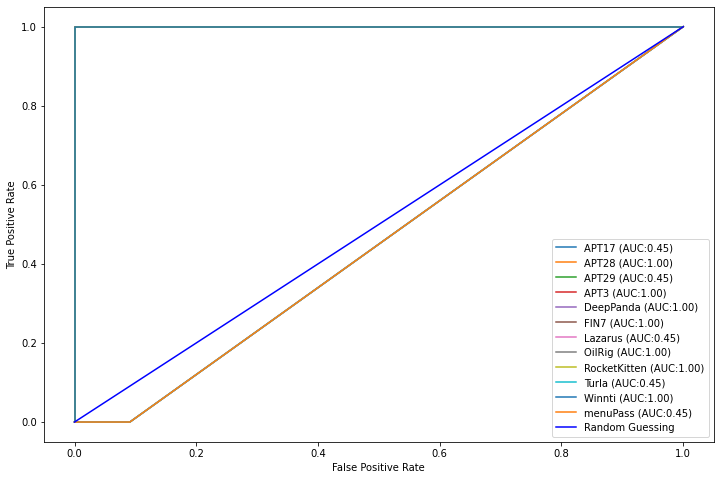

In [21]:
# ROC AUC score
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

target= class_names

print(class_names)
for (idx, c_label) in enumerate(target):
  print(f"idx, c_label", idx, c_label)

y_labels = np.concatenate([y for x, y in val_ds], axis=-1)

y_hat_probs = model.predict(val_ds)

y_hat_classes = y_hat_probs.argmax(axis=-1)

# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(y_test[idx].astype(int), y_pred[idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

print('ROC AUC score 1:', multiclass_roc_auc_score(y_labels, y_hat_classes))


c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()

ROC AUC score 2: 0.7787523749113525


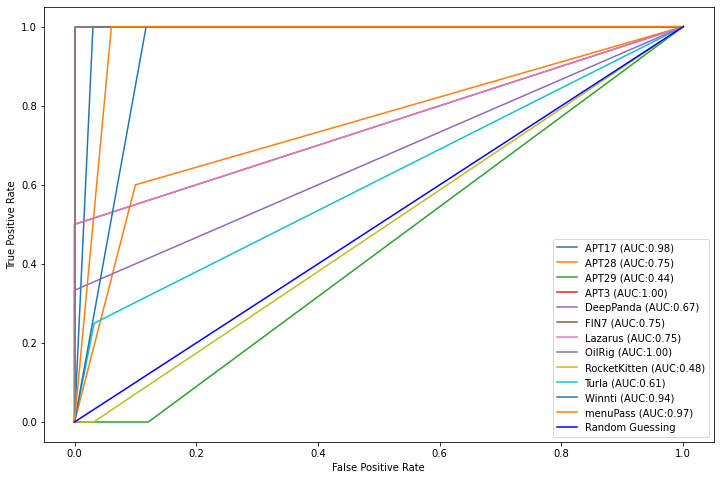

In [22]:
# ROC AUC Score
# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class2
def multiclass_roc_auc_score_2(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

print('ROC AUC score 2:', multiclass_roc_auc_score_2(y_labels, y_hat_classes))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()

## Export an end-to-end model

Now, we may want to export a `Model` object that takes as input a string of arbitrary
length, rather than a sequence of indices. It would make the model much more portable,
since you wouldn't have to worry about the input preprocessing pipeline.

Our `vectorizer` is actually a Keras layer, so it's simple: